# Summary

<p>
The main purpose of this project is to lever the data visualization options of PySpark.
Within this, a random forest classifier is applied to the breast cancer data set.
PySpark itself does not implement data visualization techniques, but there are currently three major options utilizing the Spark API's.
</p>

<ul>
<li>toPandas()</li>
<li>Pyspark_dist_explore</li>
<li>HandySpark</li>
</ul>

<p>
Pandas is a widely know analytics package used for purposes like data wrangling
and data exploration. In view of PySpark it is interesting to point out that in
Pandas data frames are in-memory, single-server data structure whereas Pyspark are
based on Resilient Distributed Datasets (RDD's). Those are distributed over
the RAM or memory of many machines (possible remotely) in a (cloud) cluster.
By transforming a Pyspark RDD into a Pandas data frame all the analytical operations
of pandas are available and so are the data visualization capabilities of
pandas, matplotlib and seaborn.
</p>

<p>
HandySpark is "Bringing pandas-like capabilities to Spark data frames!" in Pandas.
It does this in PySpark and keeps the data frames distributed. HandySpark offers
a variety of functions for data cleaning and data visualization. It also
makes Pandas accessible by leveraging the Pandas object of the handy data frame.
</p>

<a href=" https://github.com/dvgodoy/handyspark" target="_blank">Github:
HandySpark - bringing pandas-like capabilities to Spark dataframes</a>

<p>
Pyspark_dist_explore allows fast views into DataFrames.
Currently three functions are given: hist(), distplot() and pandas_histogram()
</p>

<p>
Several data sets are used in several formats like csv, json and txt.
The data sources used are stored locally.
The functions and methods applied here include SQL-queries and
SQL-calculations and domain specific PySpark operations
like select, filter, and collect.
</p>

<p>
<b>Spark architecture</b>
</p>

<img src="cluster-overview.png" alt="Smiley face" height="500" width="500"> 


# Import packages

In [1165]:
from pyspark.sql.types \
import StructType, StructField, IntegerType, StringType

import numpy as np
import pandas as pd
import math
import random
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display, HTML, display_html 
#usefull to display wide tables
import inspect



from pyspark.sql import DataFrame
from pyspark.rdd import RDD
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import lower, col
from pyspark.sql import SparkSession
from pyspark.rdd import RDD
from pyspark.sql.functions import mean, bround, round, stddev , col, avg
from pyspark.sql.types import IntegerType, FloatType
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as func

# machine learning
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql import Row

# data visualization

from pyspark_dist_explore import Histogram, hist, distplot, \
pandas_histogram
# PySpark Dataframe Distribution Explorer
# https://github.com/Bergvca/pyspark_dist_explore

from handyspark import *


# Inspect working directory

In [1166]:
cwd_1=os.getcwd()
# print(cwd_1)

dirname = os.path.dirname(cwd_1) 
# print(dirname)

path_cwd = pathlib.Path.cwd()
# print(path_cwd)

path_home = pathlib.Path.home()
# print(path_home)


# Spark set up

## Create Spark Session

<p>
Spark Session is a single point of entry to interact with Spark data frames and other data structures. Spark session accessible in the Pyspark
shell with "spark" can create DataFrames, apply queries, and register object into the Spark cluster. Spark Session is a more easy way to communicate with Spark other than in the past when it was necessary to
set up SparkConf and SparkContext.
</p>

<p>
According to Databricks "a SparkSession is beyond a time-bounded interaction, SparkSession provides a single point of entry to interact with underlying Spark functionality and allows programming Spark with DataFrame and Dataset APIs. Most importantly, it curbs the number of concepts and constructs a developer has to juggle while interacting with Spark."
</p> 
<a href="https://databricks.com/blog/2016/08/15/how-to-use-sparksession-in-apache-spark-2-0.html" target="_blank">Class SparkSession</a> 



In [1167]:
# SparkSession.builder.getOrCreate()
spark = SparkSession.builder.getOrCreate()
print(spark)
print(type(spark))

<class 'pyspark.sql.session.SparkSession'>


In [1168]:
# Access to the current metadata catalog of relational entities, 
# e.g. database(s), tables, functions, 
# table columns, and temporary views.

spark.catalog.listTables()

# At this point there are not any tables in the catalog
# https://jaceklaskowski.gitbooks.io/mastering-spark-sql/spark-sql-SparkSession.html

[Table(name='cancer_table', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='color', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='highway_table', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='iris_tbl', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='prices', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

## Inspect spark context

In [1169]:
print(sqlContext)
print(sc)
print(sc.version)
print(sc.master)
print(sc.sparkHome)
print(sc.sparkUser)
print(sc.appName)
print(sc.applicationId)
print(sc.defaultParallelism)
print(sc.defaultMinPartitions)

<SparkContext master=local[*] appName=PySparkShell>
3.0.0-preview
local[*]
None
<bound method SparkContext.sparkUser of <SparkContext master=local[*] appName=PySparkShell>>
PySparkShell
local-1579167966780
4
2


# Creating RDDs, data frames, SQL-tables from list of tuples


## Example 1: prices

In [1170]:
# Create an example list of tuples
price_list = [('car',5000), ('bus',50000),('bicycle',100),
              ('airplane',900000), ('motor bike', 2000),
              ('shoes', 50), ('train', 2000000)]

In [1171]:
# Create an RDD from a list
rdd_price = sc.parallelize(price_list)

In [1172]:
# Create a data frame from an RDD
df_price = spark.createDataFrame(rdd_price, schema=["vehicle", "price"])

# price
print(df_price)
print(type(df_price))
df_price.show()

DataFrame[vehicle: string, price: bigint]
<class 'pyspark.sql.dataframe.DataFrame'>
+----------+-------+
|   vehicle|  price|
+----------+-------+
|       car|   5000|
|       bus|  50000|
|   bicycle|    100|
|  airplane| 900000|
|motor bike|   2000|
|     shoes|     50|
|     train|2000000|
+----------+-------+



In [1173]:
df_price.printSchema()

root
 |-- vehicle: string (nullable = true)
 |-- price: long (nullable = true)



### spark.sql interface

Creating a temporary table from a data frame allows to use SQL
on the data. A temporary table is needed because SQL-queries cannot applied directly to a data frame. Spark provides with spark.sql an API
that is able to process SQL-queries.The spark.sql query returns a data frame. Using domain specific Pyspark methods like collect or show are working on this.This allows to mix up SQL and Pyspark data frame methods together. If familiarity with the SQL-language this is a great way to easily extract (structured) data.

In [1174]:
# add a table to the cataloge of the spark session
df_price.createOrReplaceTempView('prices')

In [1175]:
# the table can now be queried with SQL-syntax
# query the table
query_2 = "FROM prices SELECT *"
table_prices = spark.sql(query_2)
table_prices.show()

+----------+-------+
|   vehicle|  price|
+----------+-------+
|       car|   5000|
|       bus|  50000|
|   bicycle|    100|
|  airplane| 900000|
|motor bike|   2000|
|     shoes|     50|
|     train|2000000|
+----------+-------+



## Data visualization with toPandas

transforms Pyspark data frames into Pandas data frames.
From there on the many options of Pandas and 
other packages like matplotlib or seaborn are available.


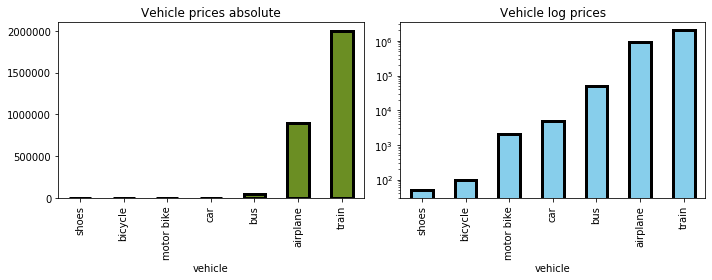

In [1176]:
table_prices_pd = table_prices.toPandas()


fig, axs = plt.subplots(1,2, tight_layout=True, figsize=(10,4))

table_prices_pd.sort_values(by='price').\
plot.bar(x='vehicle', edgecolor='black',
         linewidth=3, title="Vehicle prices absolute",
         logy=False, color=['olivedrab'],
         legend=False, ax=axs[0])


table_prices_pd.sort_values(by='price').\
plot.bar(x='vehicle', edgecolor='black',
         linewidth=3, title="Vehicle log prices",
         logy=True, color='skyblue',
         legend=False, ax=axs[1])


plt.show()

In [1177]:
# calculate the mean price
query_3 = "FROM prices SELECT AVG(price) AS mean_price"
spark.sql(query_3).show()

+----------+
|mean_price|
+----------+
|  422450.0|
+----------+



## Example 2: color codes

In [1178]:
# create a dictionary
colors_1 = \
  {
  "aliceblue": "#f0f8ff",
  "antiquewhite": "#faebd7",
  "aqua": "#00ffff",
  "aquamarine": "#7fffd4",
  "azure": "#f0ffff",
  "beige": "#f5f5dc",
  "bisque": "#ffe4c4",
  "black": "#000000",
  "blanchedalmond": "#ffebcd",
  "blue": "#0000ff",
  "blueviolet": "#8a2be2",
  "brown": "#a52a2a"
   }

colors_1.items()


dict_items([('aliceblue', '#f0f8ff'), ('antiquewhite', '#faebd7'), ('aqua', '#00ffff'), ('aquamarine', '#7fffd4'), ('azure', '#f0ffff'), ('beige', '#f5f5dc'), ('bisque', '#ffe4c4'), ('black', '#000000'), ('blanchedalmond', '#ffebcd'), ('blue', '#0000ff'), ('blueviolet', '#8a2be2'), ('brown', '#a52a2a')])

In [1179]:
# turn the dictionary into a tuple
# iteritems is depreciated in Python 3.0

color_tuples = [(k, v) for k,v in colors_1.items()]

print(color_tuples)
print(type(color_tuples))

[('aliceblue', '#f0f8ff'), ('antiquewhite', '#faebd7'), ('aqua', '#00ffff'), ('aquamarine', '#7fffd4'), ('azure', '#f0ffff'), ('beige', '#f5f5dc'), ('bisque', '#ffe4c4'), ('black', '#000000'), ('blanchedalmond', '#ffebcd'), ('blue', '#0000ff'), ('blueviolet', '#8a2be2'), ('brown', '#a52a2a')]
<class 'list'>


In [1180]:
# create schema 
# a schema controls the data frame and optimizes queries

color_schema = \
StructType([
    StructField("color", StringType(), True),
    StructField("color_code", StringType(), True)])


In [1181]:
color_rdd = sc.parallelize(color_tuples)
color_df = spark.createDataFrame(color_rdd , schema=color_schema)

print(color_df)
print(color_df.printSchema())

DataFrame[color: string, color_code: string]
root
 |-- color: string (nullable = true)
 |-- color_code: string (nullable = true)

None


In [1182]:
color_df.show()

+--------------+----------+
|         color|color_code|
+--------------+----------+
|     aliceblue|   #f0f8ff|
|  antiquewhite|   #faebd7|
|          aqua|   #00ffff|
|    aquamarine|   #7fffd4|
|         azure|   #f0ffff|
|         beige|   #f5f5dc|
|        bisque|   #ffe4c4|
|         black|   #000000|
|blanchedalmond|   #ffebcd|
|          blue|   #0000ff|
|    blueviolet|   #8a2be2|
|         brown|   #a52a2a|
+--------------+----------+



In [1183]:
color_df.createOrReplaceTempView('color')

In [1184]:
query_1 = "FROM color SELECT *"

color_1 = spark.sql(query_1)

print(type(color_1))
color_1.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------+----------+
|         color|color_code|
+--------------+----------+
|     aliceblue|   #f0f8ff|
|  antiquewhite|   #faebd7|
|          aqua|   #00ffff|
|    aquamarine|   #7fffd4|
|         azure|   #f0ffff|
|         beige|   #f5f5dc|
|        bisque|   #ffe4c4|
|         black|   #000000|
|blanchedalmond|   #ffebcd|
|          blue|   #0000ff|
|    blueviolet|   #8a2be2|
|         brown|   #a52a2a|
+--------------+----------+



Are the tables in the catalog?

In [1185]:
spark.catalog.listTables()
# Yes

[Table(name='cancer_table', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='color', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='highway_table', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='iris_tbl', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='prices', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

# Loading data into data frames

## Loading a json

In [1186]:
# read in the json version of the iris data set
iris = spark.read.format('json').load("iris.json")

# inspect the object
print(type(iris))
print("")

print(iris.show(4))

# show first row
print(iris.take(1))
print("")

# shape
print(iris.count())
print(len(iris.columns))
print(iris.columns)

<class 'pyspark.sql.dataframe.DataFrame'>

+---------------+-----------+----------+-----------+----------+-------+
|_corrupt_record|petalLength|petalWidth|sepalLength|sepalWidth|species|
+---------------+-----------+----------+-----------+----------+-------+
|              [|       null|      null|       null|      null|   null|
|           null|        1.4|       0.2|        5.1|       3.5| setosa|
|           null|        1.4|       0.2|        4.9|       3.0| setosa|
|           null|        1.3|       0.2|        4.7|       3.2| setosa|
+---------------+-----------+----------+-----------+----------+-------+
only showing top 4 rows

None
[Row(_corrupt_record='[', petalLength=None, petalWidth=None, sepalLength=None, sepalWidth=None, species=None)]

152
6
['_corrupt_record', 'petalLength', 'petalWidth', 'sepalLength', 'sepalWidth', 'species']


Deleting the corrupt column.

In [1187]:
iris_2 = iris.drop('_corrupt_record')
print(iris_2.columns)

['petalLength', 'petalWidth', 'sepalLength', 'sepalWidth', 'species']


Are there null-values?

In [1188]:
# isNull works on columns of data frames and not data frames
iris_2.select([count(when(isnan(c) | col(c).isNull(), c)).
               alias(c) for c in iris_2.columns]).show()

+-----------+----------+-----------+----------+-------+
|petalLength|petalWidth|sepalLength|sepalWidth|species|
+-----------+----------+-----------+----------+-------+
|          2|         2|          2|         2|      2|
+-----------+----------+-----------+----------+-------+



Drop null values.

In [1189]:
iris_3 = iris_2.na.drop()

In [1190]:
iris_3.select([count(when(isnan(c) | col(c).isNull(), c)).
               alias(c) for c in iris_2.columns]).show()

+-----------+----------+-----------+----------+-------+
|petalLength|petalWidth|sepalLength|sepalWidth|species|
+-----------+----------+-----------+----------+-------+
|          0|         0|          0|         0|      0|
+-----------+----------+-----------+----------+-------+



In [1191]:
print(iris_2.count())
print(iris_3.count())
# two rows with null values were removed

152
150


In [1192]:
iris_3.printSchema()

root
 |-- petalLength: double (nullable = true)
 |-- petalWidth: double (nullable = true)
 |-- sepalLength: double (nullable = true)
 |-- sepalWidth: double (nullable = true)
 |-- species: string (nullable = true)



In [1193]:
desc1 = iris_3.select('petalLength', "sepalLength").describe()
desc1.select('summary', round(desc1["petalLength"],2).alias('petall'), 
              round(desc1["sepalLength"],2).alias('sepall')).show()

+-------+------+------+
|summary|petall|sepall|
+-------+------+------+
|  count| 150.0| 150.0|
|   mean|  3.76|  5.84|
| stddev|  1.77|  0.83|
|    min|   1.0|   4.3|
|    max|   6.9|   7.9|
+-------+------+------+



Index(['petalLength', 'petalWidth', 'sepalLength', 'sepalWidth', 'species'], dtype='object')


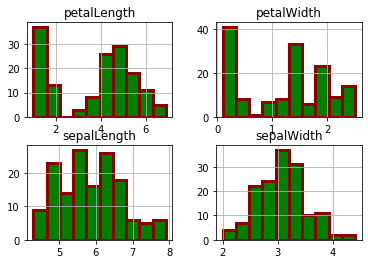

In [1194]:
# to Pandas for visualization
iris2_pd = iris_2.toPandas()
print(iris2_pd.columns)

# plot histograms of variables
iris3_pd = iris2_pd.drop('species', axis=1)
iris3_pd.hist(color='green', edgecolor="darkred", linewidth=3)
plt.show()

In [1195]:
# operation select as domain specific expression
# is needed to select a column
# Python subsetting does not work on pyspark data frames
group1 = \
iris_3.select('species', 'petalLength', "sepalLength").\
groupby('species').avg()

print(type(group1))
print(group1.show())

<class 'pyspark.sql.dataframe.DataFrame'>
+----------+------------------+-----------------+
|   species|  avg(petalLength)| avg(sepalLength)|
+----------+------------------+-----------------+
|    setosa|1.4620000000000002|5.005999999999999|
|versicolor|              4.26|            5.936|
| virginica|             5.552|6.587999999999998|
+----------+------------------+-----------------+

None


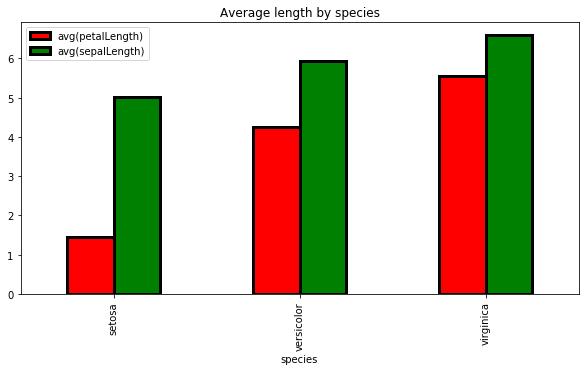

In [1196]:
group1_pd=group1.toPandas()
group1_pd.plot.bar(x='species', edgecolor='black', linewidth=3,
                   figsize=(10,5), 
                   title="Average length by species",
                   color=['red', 'green'])
plt.show()
# sepal length is on average greater

In [1197]:
# Domain specific pyspark language: filter
virgin1 = iris_2.filter(iris_2.species == 'virginica')
print(virgin1.show(5))
print(virgin1.count())

+-----------+----------+-----------+----------+---------+
|petalLength|petalWidth|sepalLength|sepalWidth|  species|
+-----------+----------+-----------+----------+---------+
|        6.0|       2.5|        6.3|       3.3|virginica|
|        5.1|       1.9|        5.8|       2.7|virginica|
|        5.9|       2.1|        7.1|       3.0|virginica|
|        5.6|       1.8|        6.3|       2.9|virginica|
|        5.8|       2.2|        6.5|       3.0|virginica|
+-----------+----------+-----------+----------+---------+
only showing top 5 rows

None
50


## Data visualization with Pyspark_dist_explore

<p>
It is a data visualization package native to Pyspark based on matplotlib. It is
installed here on Pyspark with "pip install pyspark_dist_explore". 
There are three functions to create graphs like histograms or displots. 
Thanks to Bergvca / pyspark_dist_explore. 
</p> 


<a href="https://github.com/Bergvca/pyspark_dist_explore" 
target="_blank">Github</a> 



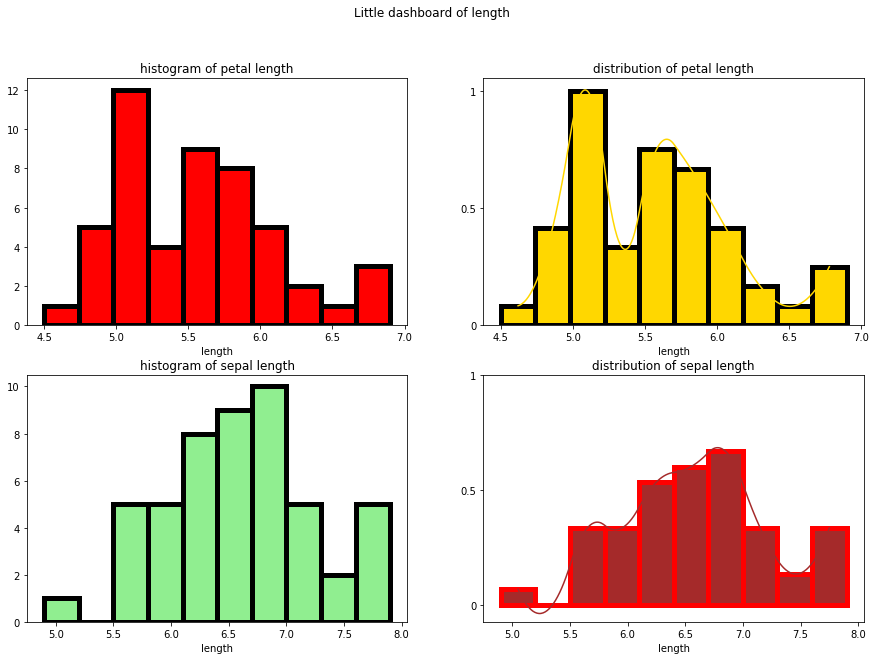

In [1198]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 10)
plt.suptitle('Little dashboard of length')

# creating data series by selecting a variable from df
petalen = virgin1.select('petalLength')
sepalen = virgin1.select('sepalLength')


# other than in matplotlib the Pyspark_dist_explore package needs
# an axes argument, otherwise the function will not work!
hist(axes[0, 0], petalen, color="red", 
     edgecolor="black", linewidth=5)
# some matplotlib arguments like edgecolor are working
axes[0,0].set_title('histogram of petal length')
axes[0,0].set_xlabel('length')

distplot(axes[0,1], petalen, color="gold", linewidth=5,
         edgecolor='black')
axes[0,1].set_title('distribution of petal length')
axes[0,1].set_xlabel('length')
axes[0,1].set_yticks([0, 0.5, 1], minor=False)

hist(axes[1,0], sepalen, color="lightgreen", edgecolor='black',
     linewidth=5)
axes[1,0].set_title('histogram of sepal length')
axes[1,0].set_xlabel('length')

distplot(axes[1,1], sepalen, color="brown", edgecolor="red", linewidth=5)
axes[1,1].set_title('distribution of sepal length')
axes[1,1].set_xlabel('length')
axes[1,1].set_yticks([0, 0.5, 1], minor=False)

plt.show()

#### spark.sql

In [1199]:
# createOrReplaceTempView('color')
# first create a temporary table
iris_2.createOrReplaceTempView('iris_tbl')

# sql.spark API
query_virgin = 'SELECT  *  FROM iris_tbl WHERE species == "virginica"'
virgin2 = spark.sql(query_virgin)

print(virgin2.show(5))
print(virgin2.count())

+-----------+----------+-----------+----------+---------+
|petalLength|petalWidth|sepalLength|sepalWidth|  species|
+-----------+----------+-----------+----------+---------+
|        6.0|       2.5|        6.3|       3.3|virginica|
|        5.1|       1.9|        5.8|       2.7|virginica|
|        5.9|       2.1|        7.1|       3.0|virginica|
|        5.6|       1.8|        6.3|       2.9|virginica|
|        5.8|       2.2|        6.5|       3.0|virginica|
+-----------+----------+-----------+----------+---------+
only showing top 5 rows

None
50


In [1200]:
print("Count with DSL is {} and the same as count with SQL of {}."\
      .format(virgin1.count(), virgin2.count()))

Count with DSL is 50 and the same as count with SQL of 50.


In [1201]:
# Maximun length
query_virgin2 = \
'SELECT MAX(sepalWidth), MAX(sepalLength), MAX(petalLength),\
MAX(petalWidth) FROM iris_tbl '

virgin2_mean = spark.sql(query_virgin2)
virgin2_mean.show(5)

+---------------+----------------+----------------+---------------+
|max(sepalWidth)|max(sepalLength)|max(petalLength)|max(petalWidth)|
+---------------+----------------+----------------+---------------+
|            4.4|             7.9|             6.9|            2.5|
+---------------+----------------+----------------+---------------+



## Loading a text file with csv

In [1202]:
# the built in csv method reads also text files
highway = spark.read.csv('OnSunsetHighways.txt')

print(type(highway))
print(highway.columns)
print(highway.count())

print("")

print(highway.take(5))

print("")

print([print(line) for line in highway.take(11)])



<class 'pyspark.sql.dataframe.DataFrame'>
['_c0']
9269

[Row(_c0=' ON SUNSET HIGHWAYS ***'), Row(_c0='Produced by Melissa McDaniel and the Online Distributed'), Row(_c0='Proofreading Team at http://www.pgdp.net (This file was'), Row(_c0='produced from images generously made available by The'), Row(_c0='Internet Archive. The map and cover are courtesy of the')]

Row(_c0=' ON SUNSET HIGHWAYS ***')
Row(_c0='Produced by Melissa McDaniel and the Online Distributed')
Row(_c0='Proofreading Team at http://www.pgdp.net (This file was')
Row(_c0='produced from images generously made available by The')
Row(_c0='Internet Archive. The map and cover are courtesy of the')
Row(_c0='California History Room')
Row(_c0='Sacramento')
Row(_c0="Transcriber's Note:")
Row(_c0='  Inconsistent hyphenation in the original document has been')
Row(_c0='  preserved. Obvious typographical errors have been corrected.')
Row(_c0='     ON SUNSET')
[None, None, None, None, None, None, None, None, None, None, None]


In [1203]:
highway.printSchema()

root
 |-- _c0: string (nullable = true)



In [1204]:
highway.createOrReplaceTempView('highway_table')

In [1205]:
# select rows where column = California
query_high_1 = "From highway_table SELECT _c0 WHERE _c0='California'"
high_cali = spark.sql(query_high_1)
print(high_cali.take(5))
print(high_cali.count())

[Row(_c0='California'), Row(_c0='California'), Row(_c0='California'), Row(_c0='California'), Row(_c0='California')]
8


## Loading a csv

with the breas cancer data set obtained from the University of Wisconsin Hospitals.
It consists of 10 features relevant for predicting cancer.
The target variable is class with 2 for benign, 4 for malignant.
The Class distribution is benign: 458 (65.5%) and malignant: 241 (34.5%).

In [1206]:
# Original column names of the breast cancer data set.
# The names are long and have spaces.
# Both is not ideal
cancer_column_names = \
["Sample_code_number","Clump Thickness", "Uniformity of Cell Size",
 "Uniformity of Cell Shape", "Adhesion",  "Single Epithelial Cell Size",
 "Bare Nuclei", "Bland Chromatin", "Normal Nucleoli", "Mitoses", 
 "Class"]

print(len(cancer_column_names))


11


In [1207]:
# using the schema to change the column names
cancer_schema = \
StructType([
    StructField("code", IntegerType(), True),
    StructField("clump", IntegerType(), True),
    StructField("cellSize", IntegerType(), True),
    StructField("cellShape", IntegerType(), True),
    StructField("Adh", IntegerType(), True),
    StructField("epithel", IntegerType(), True),
    StructField("bareNuclei", IntegerType(), True),
    StructField("chroma", IntegerType(), True),
    StructField("normalNucleoli", IntegerType(), True),
    StructField("mitose", IntegerType(), True),
    StructField("class", IntegerType(), True)])

In [1208]:
cancer = spark.read.csv("breast-cancer-wisconsin.csv", header=False,
                        inferSchema=True, schema=cancer_schema)

# inspecting the data frame
print(type(cancer))
print("")

# show first row
print(cancer.take(1))
print("")

# shape
print(cancer.count())
print(len(cancer.columns))
print(cancer.columns)

<class 'pyspark.sql.dataframe.DataFrame'>

[Row(code=1000025, clump=5, cellSize=1, cellShape=1, Adh=1, epithel=2, bareNuclei=1, chroma=3, normalNucleoli=1, mitose=1, class=2)]

699
11
['code', 'clump', 'cellSize', 'cellShape', 'Adh', 'epithel', 'bareNuclei', 'chroma', 'normalNucleoli', 'mitose', 'class']


In [1209]:
cancer.select('chroma', 'normalNucleoli', 'mitose', 'class').show(5)

+------+--------------+------+-----+
|chroma|normalNucleoli|mitose|class|
+------+--------------+------+-----+
|     3|             1|     1|    2|
|     3|             2|     1|    2|
|     3|             1|     1|    2|
|     3|             7|     1|    2|
|     3|             1|     1|    2|
+------+--------------+------+-----+
only showing top 5 rows



In [1210]:
cancer_pd = cancer.toPandas()
print(cancer_pd.head())


      code  clump  cellSize  cellShape  Adh  epithel  bareNuclei  chroma  \
0  1000025      5         1          1    1        2         1.0       3   
1  1002945      5         4          4    5        7        10.0       3   
2  1015425      3         1          1    1        2         2.0       3   
3  1016277      6         8          8    1        3         4.0       3   
4  1017023      4         1          1    3        2         1.0       3   

   normalNucleoli  mitose  class  
0               1       1      2  
1               2       1      2  
2               1       1      2  
3               7       1      2  
4               1       1      2  


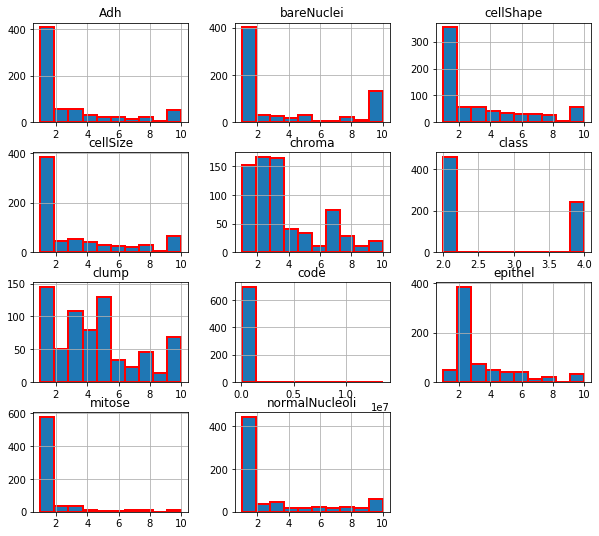

In [1211]:
# hist = df.hist(bins=3)
# plot histograms of the variables
cancer_pd.hist(figsize=(10,9), edgecolor="red", linewidth=2)
plt.show()

#### Filter

In [1212]:
# filter with domain specific language
cancer_1 = cancer.filter(cancer['mitose'] > 5 )
print(cancer_1.count())
# 139 of mitoses are greater 5

34


In [1213]:
cancer.createOrReplaceTempView('cancer_table')
qcancer_1 =\
"SELECT class, chroma, normalNucleoli, mitose FROM cancer_table WHERE Mitose > 5"

qcancer_mitoses = spark.sql(qcancer_1)
print(qcancer_mitoses.show(5))
print(qcancer_mitoses.count())

+-----+------+--------------+------+
|class|chroma|normalNucleoli|mitose|
+-----+------+--------------+------+
|    4|     7|             3|     7|
|    4|     4|             3|    10|
|    4|     8|             9|     8|
|    4|     7|             8|    10|
|    4|     7|            10|     7|
+-----+------+--------------+------+
only showing top 5 rows

None
34


In [1214]:
# domain specific language
cancer.select('class', 'chroma', 'normalNucleoli', 'mitose').\
groupBy('class').min().orderBy('class').drop('min(class)').show()

+-----+-----------+-------------------+-----------+
|class|min(chroma)|min(normalNucleoli)|min(mitose)|
+-----+-----------+-------------------+-----------+
|    2|          1|                  1|          1|
|    4|          1|                  1|          1|
+-----+-----------+-------------------+-----------+



In [1215]:
# spark.sql API
qcancer_3 = \
"SELECT class, MIN(chroma), MIN(normalNucleoli),\
MIN(mitose) FROM cancer_table GROUP BY class ORDER BY class"

qcancer_sql3 = spark.sql(qcancer_3)
qcancer_sql3.show()

+-----+-----------+-------------------+-----------+
|class|min(chroma)|min(normalNucleoli)|min(mitose)|
+-----+-----------+-------------------+-----------+
|    2|          1|                  1|          1|
|    4|          1|                  1|          1|
+-----+-----------+-------------------+-----------+



## Data visualization with HandySpark

<p>
on Github the purpose of this package is aptly describe as "bringing pandas-like capabilities to Spark dataframes".
</p> 


<a href=" https://github.com/dvgodoy/handyspark" target="_blank">Github: 
    HandySpark - bringing pandas-like capabilities to Spark dataframes</a>

In [1216]:
cancer_hdf = cancer.toHandy()

print(type(cancer_hdf ))
print(cancer_hdf.head())


<class 'handyspark.sql.dataframe.HandyFrame'>
Row(code=1000025, clump=5, cellSize=1, cellShape=1, Adh=1, epithel=2, bareNuclei=1, chroma=3, normalNucleoli=1, mitose=1, class=2)


In [1217]:
print(display(cancer_hdf.show(2)))

+-------+-----+--------+---------+---+-------+----------+------+--------------+------+-----+
|   code|clump|cellSize|cellShape|Adh|epithel|bareNuclei|chroma|normalNucleoli|mitose|class|
+-------+-----+--------+---------+---+-------+----------+------+--------------+------+-----+
|1000025|    5|       1|        1|  1|      2|         1|     3|             1|     1|    2|
|1002945|    5|       4|        4|  5|      7|        10|     3|             2|     1|    2|
+-------+-----+--------+---------+---+-------+----------+------+--------------+------+-----+
only showing top 2 rows



None

None


Subsetting is possible with handy spark using 'cols" as an entry point method into pandas.

In [1218]:
subset1 = cancer_hdf.cols['code'][:10]
print(subset1)
print(type(subset1))

0    1000025
1    1002945
2    1015425
3    1016277
4    1017023
5    1017122
6    1018099
7    1018561
8    1033078
9    1033078
Name: code, dtype: int32
<class 'pandas.core.series.Series'>


In [1219]:
subset2 = cancer_hdf.cols[['cellShape', 'epithel', 'bareNuclei']][:5]
print(subset2 )
print(type(subset2 ))

   cellShape  epithel  bareNuclei
0          1        2           1
1          4        7          10
2          1        2           2
3          8        3           4
4          1        2           1
<class 'pandas.core.frame.DataFrame'>


In [1220]:
subset3 = cancer_hdf.cols['cellShape'].value_counts()

print(subset3)
print(type(subset3))

cellShape
1     353
2      59
3      56
4      44
5      34
6      30
7      30
8      28
9       7
10     58
Name: value_counts, dtype: int64
<class 'pandas.core.series.Series'>


In [1221]:
corr_1 = cancer_hdf.cols[['cellShape', 'epithel', 'bareNuclei']].corr()

print(type(corr_1))
print(corr_1)

<class 'pandas.core.frame.DataFrame'>
            cellShape   epithel  bareNuclei
cellShape    1.000000  0.722462    0.713878
epithel      0.722462  1.000000    0.585716
bareNuclei   0.713878  0.585716    1.000000


### Null-values

In [1222]:
cancer_hdf.isnull(ratio=False)

code               0
clump              0
cellSize           0
cellShape          0
Adh                0
epithel            0
bareNuclei        16
chroma             0
normalNucleoli     0
mitose             0
class              0
Name: missing, dtype: int64

In [1223]:
cancer_hdf.isnull(ratio=True)

code              0.00000
clump             0.00000
cellSize          0.00000
cellShape         0.00000
Adh               0.00000
epithel           0.00000
bareNuclei        0.02289
chroma            0.00000
normalNucleoli    0.00000
mitose            0.00000
class             0.00000
Name: missing(ratio), dtype: float64

#### Handling missing values

In [1224]:
# missing  values substituted with the median
cancer_hdf_filled = cancer_hdf.fill(categorical=['bareNuclei'], strategy = 'median')
cancer_hdf_filled.isnull()

code              0
clump             0
cellSize          0
cellShape         0
Adh               0
epithel           0
bareNuclei        0
chroma            0
normalNucleoli    0
mitose            0
class             0
Name: missing, dtype: int64

### Plots in HandySpark

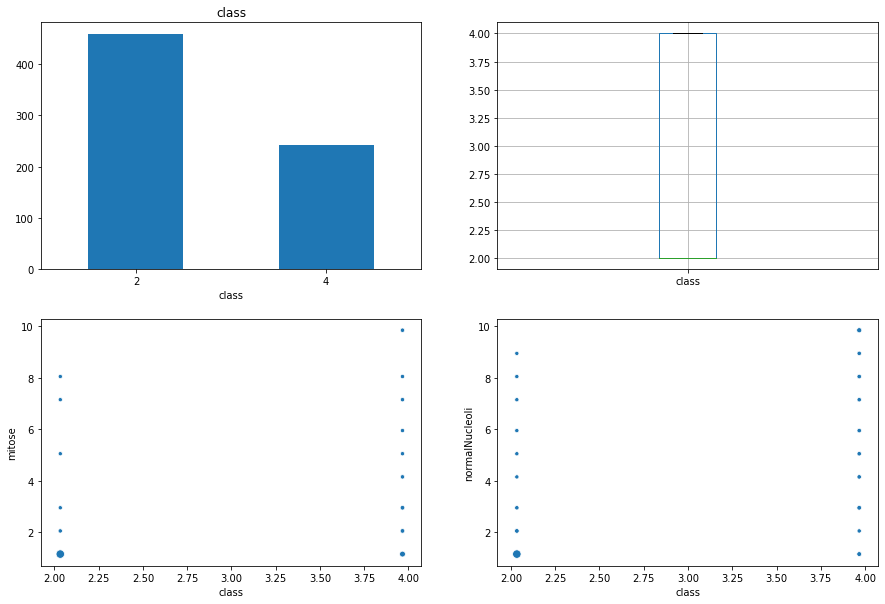

In [1225]:
# target variable class
fig, axes = plt.subplots(2,2, figsize=(15, 10))

cancer_hdf_filled.cols['class'].hist(ax=axes[0,0])
cancer_hdf_filled.cols['class'].boxplot(ax=axes[0,1])
cancer_hdf_filled.cols[['class', 'mitose']].scatterplot(ax=axes[1,0])
cancer_hdf_filled.cols[['class', 'normalNucleoli']].scatterplot(ax=axes[1,1])
plt.show()


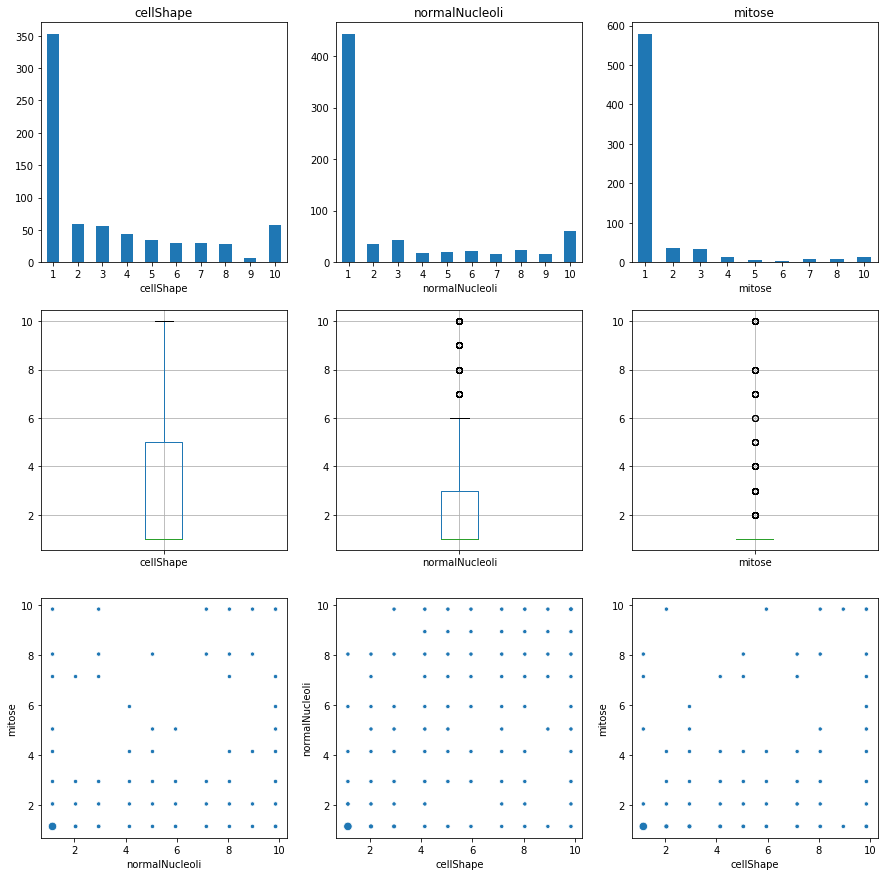

In [1226]:
fig, axes = plt.subplots(3,3)
fig.set_size_inches(15,15)

# the handy spark plot are having an ax method!!!
cancer_hdf_filled.cols['cellShape'].hist(ax=axes[0,0])
cancer_hdf_filled.cols['normalNucleoli'].hist(ax=axes[0,1])
cancer_hdf_filled.cols['mitose'].hist(ax=axes[0,2])

cancer_hdf_filled.cols['cellShape'].boxplot(ax=axes[1,0])
cancer_hdf_filled.cols['normalNucleoli'].boxplot(ax=axes[1,1])
cancer_hdf_filled.cols['mitose'].boxplot(ax=axes[1,2])


cancer_hdf_filled.cols[['normalNucleoli', 'mitose']].scatterplot(ax=axes[2,0])
cancer_hdf_filled.cols[['cellShape', 'normalNucleoli']].scatterplot(ax=axes[2,1])
cancer_hdf_filled.cols[['cellShape', 'mitose']].scatterplot(ax=axes[2,2])


plt.show()

There are outliers in the given variables.

#### Stratification

by splitting the data set on discrete columns with a limited number 
of value states and then applying an aggregate function.

In [1227]:
cancer_hdf_filled.stratify(['class']).cols['chroma'].value_counts()

class  chroma
2      1         150
       2         159
       3         129
       4           8
       5           4
       6           1
       7           7
4      1           2
       2           7
       3          36
       4          32
       5          30
       6           9
       7          66
       8          28
       9          11
       10         20
Name: value_counts, dtype: int64

In [1228]:
# stratifying on a column containing continuous values
# is done by creating buckets or bins or ranges
# does here not work perfectly as all variables are of type integer
cancer_hdf_filled.stratify(['class', Bucket('chroma',3)]).cols['mitose'].value_counts()

class  chroma                                  mitose
2      chroma >= 1.0000 and chroma < 4.0000    1         427
                                               2           6
                                               3           2
                                               5           1
                                               7           1
                                               8           1
       chroma >= 4.0000 and chroma < 7.0000    1          12
                                               2           1
       chroma >= 7.0000 and chroma <= 10.0000  1           6
                                               2           1
4      chroma >= 1.0000 and chroma < 4.0000    1          25
                                               2           8
                                               3           5
                                               4           1
                                               5           1
                               

### Detecting outliers with the Tukey's method

In [1229]:
cancer_hdf_filled.outliers(method='tukey', k=3.)

code                2
clump               0
cellSize            0
cellShape           0
Adh                55
epithel             0
bareNuclei          0
chroma              0
normalNucleoli     61
mitose            120
class               0
Name: outliers, dtype: int64

In [1230]:
cancer_out = cancer_hdf_filled.fence(['mitose', 'Adh', 'code', 'normalNucleoli'])

print(type(cancer_out))
print(cancer_out.columns)

<class 'handyspark.sql.dataframe.HandyFrame'>
['code', 'clump', 'cellSize', 'cellShape', 'Adh', 'epithel', 'bareNuclei', 'chroma', 'normalNucleoli', 'mitose', 'class']


In [1231]:
cancer_out.fences_

{'mitose': [1.0, 1.0],
 'Adh': [-2.0, 6.0],
 'code': [339517.0, 1773581.0],
 'normalNucleoli': [-2.0, 6.0]}

In [1232]:
cancer_out.outliers(method='tukey', k=3.)

clump         0
cellSize      0
cellShape     0
epithel       0
bareNuclei    0
chroma        0
class         0
Name: outliers, dtype: int64

The outliers are gone.

In [1233]:
# for whatever reason at least here 
# fence turns the processed column into an object
# this throws an error when trying to plot it
# the column is over pandas converted to a numeric
cancer_out.printSchema()

root
 |-- code: decimal(11,1) (nullable = false)
 |-- clump: integer (nullable = true)
 |-- cellSize: integer (nullable = true)
 |-- cellShape: integer (nullable = true)
 |-- Adh: decimal(11,1) (nullable = false)
 |-- epithel: integer (nullable = true)
 |-- bareNuclei: integer (nullable = true)
 |-- chroma: integer (nullable = true)
 |-- normalNucleoli: decimal(11,1) (nullable = false)
 |-- mitose: decimal(11,1) (nullable = false)
 |-- class: integer (nullable = true)



In [1234]:
cancer_out.cols['normalNucleoli'][:5]

0    1.0
1    2.0
2    1.0
3    6.0
4    1.0
Name: normalNucleoli, dtype: object

In [1235]:
cancer_out3=cancer_out.toPandas()
print(cancer_out3.info())


INFO: Safety is ON - returning up to 1000 instances.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
code              699 non-null object
clump             699 non-null int32
cellSize          699 non-null int32
cellShape         699 non-null int32
Adh               699 non-null object
epithel           699 non-null int32
bareNuclei        699 non-null int32
chroma            699 non-null int32
normalNucleoli    699 non-null object
mitose            699 non-null object
class             699 non-null int32
dtypes: int32(7), object(4)
memory usage: 41.1+ KB
None


In [1236]:
cancer_out3.head()

,code,clump,cellSize,cellShape,Adh,epithel,bareNuclei,chroma,normalNucleoli,mitose,class
0,1000025.0,5,1,1,1.0,2,1,3,1.0,1.0,2
1,1002945.0,5,4,4,5.0,7,10,3,2.0,1.0,2
2,1015425.0,3,1,1,1.0,2,2,3,1.0,1.0,2
3,1016277.0,6,8,8,1.0,3,4,3,6.0,1.0,2
4,1017023.0,4,1,1,3.0,2,1,3,1.0,1.0,2


In [1237]:
cancer_out3['Adh'] = cancer_out3['Adh'].astype(float)
cancer_out3['normalNucleoli'] = cancer_out3['normalNucleoli'].astype(float)
cancer_out3['mitose'] = cancer_out3['mitose'].astype(float)

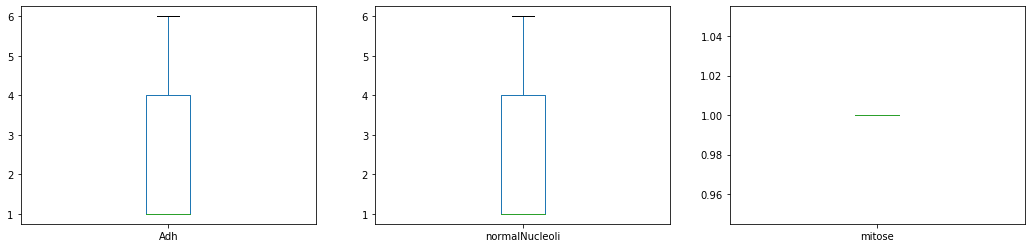

In [1238]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(18,4)

# for a plot array consisting of one row the axes argument is only a single number
cancer_out3['Adh'].plot.box(ax=axes[0])
cancer_out3['normalNucleoli'].plot.box(ax=axes[1])
cancer_out3['mitose'].plot.box(ax=axes[2])

plt.show()

The outliers are gone.

In [1239]:
cancer_fencer = cancer_out.transformers.fencer()
print(type(cancer_fencer))


<class 'handyspark.ml.base.HandyFencer'>


# Machine learning

In [1240]:
print(type(cancer_out3))
print(type(cancer_out))

# class is the target variable
print(cancer_out.columns)

<class 'pandas.core.frame.DataFrame'>
<class 'handyspark.sql.dataframe.HandyFrame'>
['code', 'clump', 'cellSize', 'cellShape', 'Adh', 'epithel', 'bareNuclei', 'chroma', 'normalNucleoli', 'mitose', 'class']


"Spark withColumn() function is used to rename, change the value, convert the datatype of an existing DataFrame column and also can be used to create a new column, on this post, I will walk you through commonly used DataFrame column operations with Scala and Pyspark examples."

<a href="https://sparkbyexamples.com/spark/spark-dataframe-withcolumn/" target="_blank">Spark DataFrame withColumn</a> 

In [1241]:

# add a new column to the existing column
cancer_out2 = \
cancer_out.withColumn('label', cancer_out['class'])

# drop the redundant column
cancer_out2=cancer_out2.drop('class')

print(cancer_out2.columns)

print(cancer_out2.select('label').show(3))
print(cancer_out2.select('label').distinct().show(3))

['code', 'clump', 'cellSize', 'cellShape', 'Adh', 'epithel', 'bareNuclei', 'chroma', 'normalNucleoli', 'mitose', 'label']
+-----+
|label|
+-----+
|    2|
|    2|
|    2|
+-----+
only showing top 3 rows

None
+-----+
|label|
+-----+
|    2|
|    4|
+-----+

None


## Train-test-split

In [1242]:


training, test=cancer_out2.randomSplit([0.7, 0.3])

print(type(training))
print("")
print("dimensions training set: nrows: {} , ncols: {}".
      format(training.count(), len(training.columns)))
print("dimensions test set: nrows: {} , ncols: {}".
      format(test.count(), len(test.columns)))
print("")
print(training.columns)

<class 'pyspark.sql.dataframe.DataFrame'>

dimensions training set: nrows: 481 , ncols: 11
dimensions test set: nrows: 218 , ncols: 11

['code', 'clump', 'cellSize', 'cellShape', 'Adh', 'epithel', 'bareNuclei', 'chroma', 'normalNucleoli', 'mitose', 'label']


## Random Forest model

In [1243]:
features = ['code', 'clump', 'cellSize', 'cellShape', 'Adh', 'epithel', 
            'bareNuclei', 'chroma', 'normalNucleoli', 'mitose']

In [1244]:
vector = VectorAssembler(inputCols= features, outputCol='features')

In [1245]:
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=20)
print(type(rf_classifier))

<class 'pyspark.ml.classification.RandomForestClassifier'>


In [1246]:
pipeline = Pipeline(stages=[vector, rf_classifier])
print(type(pipeline))

<class 'pyspark.ml.pipeline.Pipeline'>


In [1247]:
rf_model = pipeline.fit(training)

In [1248]:
predictions = rf_model.transform(test)

print(type(predictions))
print(predictions.columns)
print(predictions.select('features').show(5))

<class 'pyspark.sql.dataframe.DataFrame'>
['code', 'clump', 'cellSize', 'cellShape', 'Adh', 'epithel', 'bareNuclei', 'chroma', 'normalNucleoli', 'mitose', 'label', 'features', 'rawPrediction', 'probability', 'prediction']
+--------------------+
|            features|
+--------------------+
|[339517.0,1.0,1.0...|
|[339517.0,3.0,1.0...|
|[339517.0,3.0,3.0...|
|[339517.0,5.0,4.0...|
|[339517.0,5.0,8.0...|
+--------------------+
only showing top 5 rows

None


In [1249]:
select_23 = \
['label', 'rawPrediction', 'probability', 'prediction']

In [1250]:
display(predictions.select(select_23).show(5))

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|    2|[0.0,0.0,15.67774...|[0.0,0.0,0.783887...|       2.0|
|    2|[0.0,0.0,19.94571...|[0.0,0.0,0.997285...|       2.0|
|    4|[0.0,0.0,1.207462...|[0.0,0.0,0.060373...|       4.0|
|    2|[0.0,0.0,14.70003...|[0.0,0.0,0.735001...|       2.0|
|    4|[0.0,0.0,1.126717...|[0.0,0.0,0.056335...|       4.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



None

### Evaluating the model with the area under the receiver operating curve

In [1251]:
# evaluating predictions by building the ratio 
# of actual values versus predicted values 
evaluator = BinaryClassificationEvaluator(labelCol='label')
auc = evaluator.evaluate(predictions)
print("Area under the curve - AUC: {}".format(auc))
# an auc of 1 is perfect

Area under the curve - AUC: 1.0


The BinaryClassificationMetrics (bcm) function takes the predictions evaluates those.

In [1252]:
bcm = \
BinaryClassificationMetrics(predictions, scoreCol='probability', 
                            labelCol='label')

print(type(bcm))


<class 'pyspark.mllib.evaluation.BinaryClassificationMetrics'>


Handy Spark also offers function to plot the roc curve.
The plots are mirroring the perfect predictions.

In [1253]:
# import inspect
source_DF = inspect.getsource(bcm.plot_roc_curve)
print(source_DF)

def plot_roc_curve(self, ax=None):
    """Makes a plot of Receiver Operating Characteristic (ROC) curve.

    Parameter
    ---------
    ax : matplotlib axes object, default None
    """
    metrics = self.getMetricsByThreshold().toPandas()
    return roc_curve(metrics.fpr, metrics.recall, self.areaUnderROC, ax)



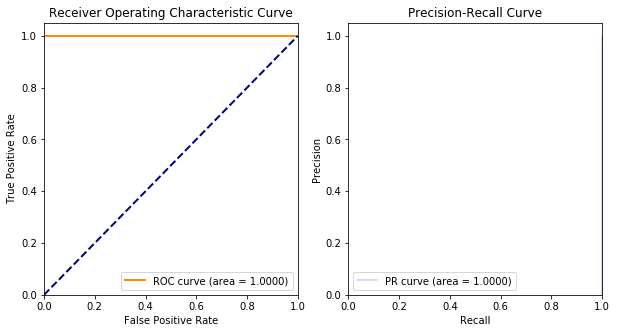

In [1254]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])
plt.show()

Within bcm are the metrics stored.



In [1255]:
bcm.getMetricsByThreshold().toPandas()

,threshold,fpr,recall,precision
0,0.0,0.0,1.0,1.0
1,0.0,1.0,1.0,0.0
